In [67]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from shutil import copyfile
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

train_folder = "/kaggle/input/traindata/train_data"
train_set_folder = "/kaggle/working/train_set"
val_set_folder = "/kaggle/working/val_set"

class_folders = [f.path for f in os.scandir(train_folder) if f.is_dir()]

for class_folder in class_folders:
    class_name = os.path.basename(class_folder)
    images = [f.path for f in os.scandir(class_folder) if f.is_file()]
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    for image in train_images:
        dest_folder = os.path.join(train_set_folder, class_name)
        os.makedirs(dest_folder, exist_ok=True)
        copyfile(image, os.path.join(dest_folder, os.path.basename(image)))

    for image in val_images:
        dest_folder = os.path.join(val_set_folder, class_name)
        os.makedirs(dest_folder, exist_ok=True)
        copyfile(image, os.path.join(dest_folder, os.path.basename(image)))
        
# Set the image size and number of classes
img_width, img_height = 224, 224
num_classes = 10

# Set up the data generators for training and validation
train_data_dir = './train_set/'
batch_size = 20

train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical', shuffle= True)

val_data_dir = './val_set'
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical', shuffle= False)

Found 7990 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [100]:
### Add one dropout - No lr schedule named dr_com

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from shutil import copyfile
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

train_folder = "/kaggle/input/traindata/train_data"
train_set_folder = "/kaggle/working/train_set"
val_set_folder = "/kaggle/working/val_set"

class_folders = [f.path for f in os.scandir(train_folder) if f.is_dir()]

for class_folder in class_folders:
    class_name = os.path.basename(class_folder)
    images = [f.path for f in os.scandir(class_folder) if f.is_file()]
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    for image in train_images:
        dest_folder = os.path.join(train_set_folder, class_name)
        os.makedirs(dest_folder, exist_ok=True)
        copyfile(image, os.path.join(dest_folder, os.path.basename(image)))

    for image in val_images:
        dest_folder = os.path.join(val_set_folder, class_name)
        os.makedirs(dest_folder, exist_ok=True)
        copyfile(image, os.path.join(dest_folder, os.path.basename(image)))
        
# Set the image size and number of classes
img_width, img_height = 224, 224
num_classes = 10

# Set up the data generators for training and validation
train_data_dir = './train_set/'
batch_size = 15

train_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical', shuffle= True)

val_data_dir = './val_set'
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical', shuffle= False)
log = tf.keras.callbacks.CSVLogger('dr_com.csv', separator=",", append=False)
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True), log]
from keras.models import Model
Res = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# for layer in Res.layers:
#     layer.trainable = False
for layer in Res.layers[:-5]:
    layer.trainable = False
x = Flatten()(Res.output)
x = Dense(256, activation='relu')(x)
x =  Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)



model = Model(inputs=Res.input, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, validation_data=val_generator, epochs=80, callbacks = callback)



Found 7990 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/80
533/533 [==============================] - 31s 51ms/step - loss: 3.5482 - accuracy: 0.2156 - val_loss: 2.0113 - val_accuracy: 0.3095
Epoch 2/80
533/533 [==============================] - 26s 48ms/step - loss: 2.0681 - accuracy: 0.2676 - val_loss: 1.8746 - val_accuracy: 0.3555
Epoch 3/80
533/533 [==============================] - 25s 48ms/step - loss: 1.9223 - accuracy: 0.3084 - val_loss: 1.7732 - val_accuracy: 0.3935
Epoch 4/80
533/533 [==============================] - 25s 47ms/step - loss: 1.8933 - accuracy: 0.3269 - val_loss: 1.7595 - val_accuracy: 0.4100
Epoch 5/80
533/533 [==============================] - 26s 48ms/step - loss: 1.8072 - accuracy: 0.3553 - val_loss: 1.6800 - val_accuracy: 0.4450
Epoch 6/80
533/533 [==============================] - 25s 47ms/step - loss: 1.7240 - accuracy: 0.3851 - val_loss: 1.6694 - val_accuracy: 0.4040
Epoch 7/80
533/533 [==============================

In [102]:
### Add one dropout and lr schedule named dr_lr

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from shutil import copyfile
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

train_folder = "/kaggle/input/traindata/train_data"
train_set_folder = "/kaggle/working/train_set"
val_set_folder = "/kaggle/working/val_set"

class_folders = [f.path for f in os.scandir(train_folder) if f.is_dir()]

for class_folder in class_folders:
    class_name = os.path.basename(class_folder)
    images = [f.path for f in os.scandir(class_folder) if f.is_file()]
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    for image in train_images:
        dest_folder = os.path.join(train_set_folder, class_name)
        os.makedirs(dest_folder, exist_ok=True)
        copyfile(image, os.path.join(dest_folder, os.path.basename(image)))

    for image in val_images:
        dest_folder = os.path.join(val_set_folder, class_name)
        os.makedirs(dest_folder, exist_ok=True)
        copyfile(image, os.path.join(dest_folder, os.path.basename(image)))
        
# Set the image size and number of classes
img_width, img_height = 224, 224
num_classes = 10

# Set up the data generators for training and validation
train_data_dir = './train_set/'
batch_size = 15

train_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical', shuffle= True)

val_data_dir = './val_set'
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical', shuffle= False)
# Define a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

# Create the optimizer with the learning rate schedule
optimizer = Adam(learning_rate=lr_schedule)
from keras.models import Model
log = tf.keras.callbacks.CSVLogger('dr_lr.csv', separator=",", append=False)
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10), log]
Res = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# for layer in Res.layers:
#     layer.trainable = False
for layer in Res.layers[:-5]:
    layer.trainable = False
x = Flatten()(Res.output)
x = Dense(256, activation='relu')(x)
x =  Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)


model = Model(inputs=Res.input, outputs=x)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, validation_data=val_generator, epochs=80, callbacks = callback)



Found 7990 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/80
533/533 [==============================] - 30s 49ms/step - loss: 3.2953 - accuracy: 0.2175 - val_loss: 2.0250 - val_accuracy: 0.3140
Epoch 2/80
533/533 [==============================] - 25s 48ms/step - loss: 2.0832 - accuracy: 0.2683 - val_loss: 1.8825 - val_accuracy: 0.3510
Epoch 3/80
533/533 [==============================] - 25s 47ms/step - loss: 2.0025 - accuracy: 0.2925 - val_loss: 1.8268 - val_accuracy: 0.3690
Epoch 4/80
533/533 [==============================] - 25s 48ms/step - loss: 1.8750 - accuracy: 0.3300 - val_loss: 1.8042 - val_accuracy: 0.4195
Epoch 5/80
533/533 [==============================] - 25s 47ms/step - loss: 1.8106 - accuracy: 0.3441 - val_loss: 1.7582 - val_accuracy: 0.4315
Epoch 6/80
533/533 [==============================] - 25s 47ms/step - loss: 1.7279 - accuracy: 0.3747 - val_loss: 1.6704 - val_accuracy: 0.4200
Epoch 7/80
533/533 [==============================

In [104]:
###add 2 dropout and lr_schedule named dr_2
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from shutil import copyfile
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

train_folder = "/kaggle/input/traindata/train_data"
train_set_folder = "/kaggle/working/train_set"
val_set_folder = "/kaggle/working/val_set"

class_folders = [f.path for f in os.scandir(train_folder) if f.is_dir()]

for class_folder in class_folders:
    class_name = os.path.basename(class_folder)
    images = [f.path for f in os.scandir(class_folder) if f.is_file()]
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    for image in train_images:
        dest_folder = os.path.join(train_set_folder, class_name)
        os.makedirs(dest_folder, exist_ok=True)
        copyfile(image, os.path.join(dest_folder, os.path.basename(image)))

    for image in val_images:
        dest_folder = os.path.join(val_set_folder, class_name)
        os.makedirs(dest_folder, exist_ok=True)
        copyfile(image, os.path.join(dest_folder, os.path.basename(image)))
        
# Set the image size and number of classes
img_width, img_height = 224, 224
num_classes = 10

# Set up the data generators for training and validation
train_data_dir = './train_set/'
batch_size = 15

train_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical', shuffle= True)

val_data_dir = './val_set'
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical', shuffle= False)
# Define a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)
log = tf.keras.callbacks.CSVLogger('dr_2.csv', separator=",", append=False)
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50), log]
# Create the optimizer with the learning rate schedule
optimizer = Adam(learning_rate=lr_schedule)
from keras.models import Model
Res = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# for layer in Res.layers:
#     layer.trainable = False
for layer in Res.layers[:-5]:
    layer.trainable = False
x = Flatten()(Res.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x =  Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)



model = Model(inputs=Res.input, outputs=x)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, validation_data=val_generator, epochs=80, callbacks = callback)



Found 7990 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/80
533/533 [==============================] - 31s 50ms/step - loss: 3.0763 - accuracy: 0.2185 - val_loss: 2.1055 - val_accuracy: 0.2740
Epoch 2/80
533/533 [==============================] - 26s 48ms/step - loss: 2.0652 - accuracy: 0.2678 - val_loss: 1.8514 - val_accuracy: 0.3545
Epoch 3/80
533/533 [==============================] - 26s 49ms/step - loss: 1.9324 - accuracy: 0.3186 - val_loss: 1.7530 - val_accuracy: 0.4325
Epoch 4/80
533/533 [==============================] - 26s 48ms/step - loss: 1.8416 - accuracy: 0.3478 - val_loss: 1.6886 - val_accuracy: 0.4305
Epoch 5/80
533/533 [==============================] - 25s 47ms/step - loss: 1.7513 - accuracy: 0.3668 - val_loss: 1.6274 - val_accuracy: 0.4480
Epoch 6/80
533/533 [==============================] - 25s 48ms/step - loss: 1.6928 - accuracy: 0.3887 - val_loss: 1.6338 - val_accuracy: 0.4395
Epoch 7/80
533/533 [==============================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



**Add one dropout**
* loss: 0.9951 - accuracy: 0.6499 - val_loss: 1.9504 - val_accuracy: 0.5265

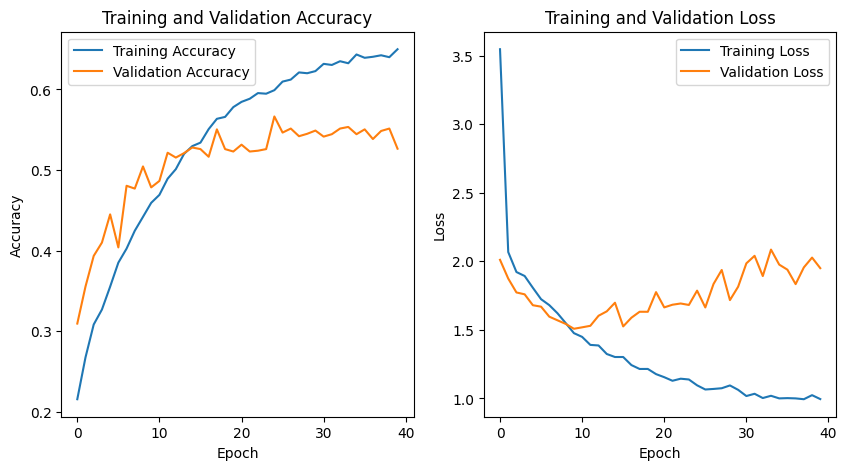

In [101]:
### Add one dropout
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('dr_com.csv')
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(df['accuracy'], label='Training Accuracy')
plt.plot(df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(df['loss'], label='Training Loss')
plt.plot(df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

**Add one dropout and schedule lr**
* loss: 1.2442 - accuracy: 0.5468 - val_loss: 1.6121 - val_accuracy: 0.5050

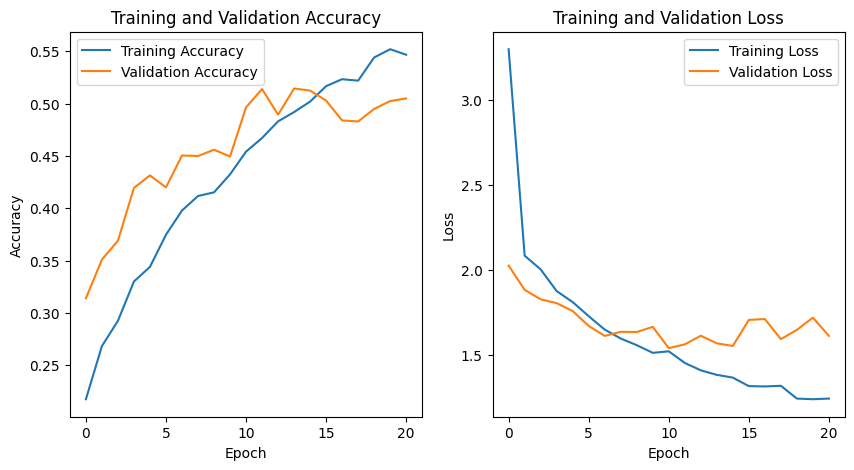

In [103]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('dr_lr.csv')
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(df['accuracy'], label='Training Accuracy')
plt.plot(df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(df['loss'], label='Training Loss')
plt.plot(df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


**add 2 dropout and lr_schedule**
* loss: 1.2131 - accuracy: 0.5641 - val_loss: 1.6518 - val_accuracy: 0.5290

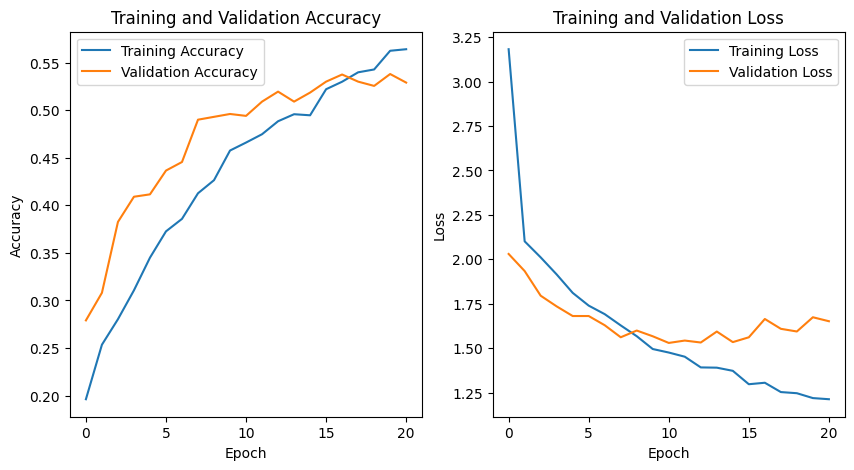

In [98]:
### Add two dropout
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('dr_2.csv')
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(df['accuracy'], label='Training Accuracy')
plt.plot(df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(df['loss'], label='Training Loss')
plt.plot(df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

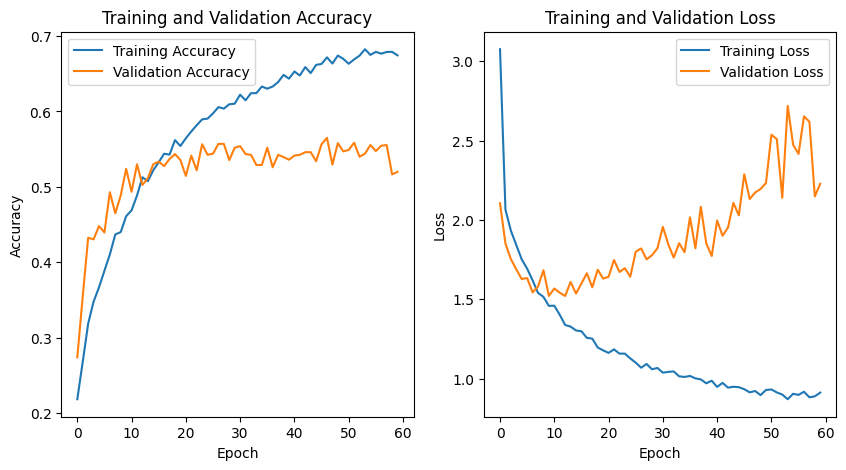

In [109]:
### Add two dropout higher epochs
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('dr_2.csv')
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(df['accuracy'], label='Training Accuracy')
plt.plot(df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(df['loss'], label='Training Loss')
plt.plot(df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()